In [52]:
import sys
import os
import json

import numpy as np
import pandas as pd
import time
import re
import datetime
import pickle
import yaml
import gc
import warnings
import matplotlib.pyplot as plt
import japanize_matplotlib # 日本語対応
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm, tqdm_notebook
import category_encoders as ce

tqdm.pandas()
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:.3f}'.format
%matplotlib inline


CONFIG_FILE = '../configs/config.yaml'
with open(CONFIG_FILE) as file:
    yml = yaml.safe_load(file)

MODEL_DIR_NAME = yml['SETTING']['MODEL_DIR_NAME']
SUB_DIR_NAME = yml['SETTING']['SUB_DIR_NAME']
RAW_DATA_DIR_NAME = yml['SETTING']['RAW_DATA_DIR_NAME']
FEATURE_DIR_NAME = yml['SETTING']['FEATURE_DIR_NAME']

In [53]:
train_df = pd.read_pickle(FEATURE_DIR_NAME + 'train.pkl')
test_df = pd.read_pickle(FEATURE_DIR_NAME + 'test.pkl')

In [59]:
umap_df = pd.read_pickle(FEATURE_DIR_NAME + 'title_bert_umap_10d.pkl')

In [60]:
umap_df

,title_bert_umap1,title_bert_umap2,title_bert_umap3,title_bert_umap4,title_bert_umap5,title_bert_umap6,title_bert_umap7,title_bert_umap8,title_bert_umap9,title_bert_umap10
0,4.881,-0.082,0.431,-0.097,0.111,0.813,0.651,-0.200,-0.995,0.337
1,3.610,-0.421,0.369,0.393,-0.458,0.395,1.258,-1.298,-0.524,0.333
2,4.873,-0.277,0.479,-0.249,1.016,0.919,1.143,0.538,-1.295,0.664
3,5.440,0.757,0.274,-0.190,-2.013,-0.195,-0.560,-1.349,-0.949,-0.029
4,5.317,-0.348,0.830,-0.867,1.248,1.303,0.689,0.962,-1.851,0.826
...,...,...,...,...,...,...,...,...,...,...
49297,6.779,-0.766,-0.466,-2.748,3.369,0.579,-0.382,1.479,-0.435,1.918
49298,4.494,-0.421,0.273,-0.078,1.033,0.365,1.201,0.602,-1.066,0.377
49299,6.171,-0.537,0.063,-1.258,2.563,0.915,0.798,1.346,-1.134,1.476
49300,5.820,-0.282,-0.381,0.167,3.000,1.163,3.082,1.419,-0.975,2.041


In [54]:
train_df.head()

,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y,title_len,publishedAt_hour,publishedAt_minute,publishedAt_year,publishedAt_quarter,publishedAt_month,publishedAt_week,publishedAt_day,publishedAt_dayofweek,publishedAt_is_weekend,publishedAt_quarter_cos,publishedAt_quarter_sin,publishedAt_month_cos,publishedAt_month_sin,publishedAt_day_cos,publishedAt_day_sin,publishedAt_dayofweek_cos,publishedAt_dayofweek_sin,loo_encode_channelId_likes,loo_encode_channelId_dislikes,loo_encode_channelId_comment_count,catboost_encode_channelId_likes,catboost_encode_channelId_dislikes,catboost_encode_channelId_comment_count,loo_encode_categoryId_likes,loo_encode_categoryId_dislikes,loo_encode_categoryId_comment_count,catboost_encode_categoryId_likes,catboost_encode_categoryId_dislikes,catboost_encode_categoryId_comment_count,collection_date_after,collection_date_year,collection_date_quarter,collection_date_month,collection_date_week,collection_date_day,collection_date_dayofweek,collection_date_is_weekend,collection_date_quarter_cos,collection_date_quarter_sin,collection_date_month_cos,collection_date_month_sin,collection_date_day_cos,collection_date_day_sin,collection_date_dayofweek_cos,collection_date_dayofweek_sin,tags_num,tags_length,tags_point,tags_count_en,tags_count_ja,likes_log,likes_sqrt,dislikes_log,dislikes_sqrt,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,comment_count_log,likes_comments,dislikes_comments,comments_likes,description_len,description_ishttp_in,delta,delta_log,delta_sqrt,delta_published,delta_collection,channel_continue_day,delta_month,delta_published_month,channel_continue_month,like_per_day,dislike_per_day,comment_count_per_day,like_per_month,dislike_per_month,comment_count_per_month,like_per_published_day,dislike_per_published_day,comment_count_per_published_day,like_per_published_month,dislike_per_published_month,comment_count_per_published_month,like_per_channel_continue_day,dislike_per_channel_continue_day,comment_count_channel_continue_day,like_per_channel_continue_month,dislike_per_channel_continue_month,comment_count_channel_continue_month,isJa_title,isJa_tags,isJa_description,isEn_title,isEn_tags,isEn_description,conEn_title,conEn_tags,conEn_description,in_music_title,in_music_tags,in_music_description,in_ff,in_OffChannell,in_OffJa,in_OffChannellJa,in_cm_title,in_cm_tags,in_cm_description,in_video_title,in_video_tags,in_video_description,in_song_title,in_song_tags,in_song_description,in_kids_title,in_kids_tags,in_kids_description,in_animeJa_title,in_animeJa_tags,in_animeJa_description,in_nursery_title,in_nursery_tags,in_nursery_description,in_nurseryJa_title,in_nurseryJa_tags,in_nurseryJa_description,in_exile_title,in_exile_tags,in_exile_description,in_3rd_title,in_3rd_tags,...,in_word_nursery_likes_count,in_word_nursery_likes_sum,in_word_nursery_likes_q10,in_word_nursery_likes_q25,in_word_nursery_likes_q50,in_word_nursery_likes_q75,in_word_nursery_likes_q90,in_word_nursery_likes_max_minus_q90,in_word_nursery_likes_max_minus_q75,in_word_nursery_likes_max_minus_q50,in_word_nursery_likes_mean_minus_q90,in_word_nursery_likes_mean_minus_q75,in_word_nursery_likes_mean_minus_q50,in_word_nursery_likes_mean_diff,in_word_nursery_likes_max_diff,in_word_nursery_likes_min_diff,in_word_nursery_dislikes_mean,in_word_nursery_dislikes_max,in_word_nursery_dislikes_min,in_word_nursery_dislikes_std,in_word_nursery_dislikes_count,in_word_nursery_dislikes_sum,in_word_nursery_dislikes_q10,in_word_nursery_dislikes_q25,in_word_nursery_dislikes_q50,in_word_nursery_dislikes_q75,in_word_nursery_dislikes_q90,in_word_nursery_dislikes_max_minus_q90,in_word_nursery_dislikes_max_minus_q75,in_word_nursery_dislikes_max_minus_q50,in_word_nursery_dislikes_mean_minus_q90,in_word_nursery_dislikes_mean_minus_q75,in_word_nursery_dislikes_mean_minus_q50,in_word_nursery_dislikes_mean_diff,in_word_nursery_dislik

In [57]:
train_df[['title_bert_umap2']].isnull().sum()

title_bert_umap2    0
dtype: int64

In [58]:
test_df[['title_bert_umap2']].isnull().sum()

title_bert_umap2    0
dtype: int64

# 外れ値

In [55]:
train_df[['y']].describe()

,y
count,19708.000
mean,3151980.964
std,18479294.979
min,2.000
25%,69330.500
50%,314253.500
75%,1309302.000
max,599555969.000


In [50]:
train_df[['title', 'channelId', 'channelTitle', 'categoryId', 'y']].sort_values('y', ascending=False).head(20)

,title,channelId,channelTitle,categoryId,y
5180,Phonics Song with TWO Words - A For Apple - AB...,3285,ChuChu TV Nursery Rhymes & Kids Songs,27,2142560416.000
10251,Numb (Official Video) - Linkin Park,1912,Linkin Park,10,1302069522.000
7284,Nirvana - Smells Like Teen Spirit,3277,NirvanaVEVO,10,1014758178.000
10857,a-ha - Take On Me (Official 4K Music Video),5793,a-ha,10,986528880.000
12003,The Cranberries - Zombie (Official Music Video),1110,TheCranberriesVEVO,10,982938184.000
6547,Rahat Fateh Ali Khan - Zaroori Tha,3933,RahatFAKhanVEVO,10,829031656.000
17085,Cyndi Lauper - Girls Just Want To Have Fun (Of...,1868,CyndiLauperVEVO,10,804387847.000
6101,No Doubt - Don't Speak (Official Music Video),2272,NoDoubtVEVO,10,723090536.000
14538,Miley Cyrus - Party In The U.S.A.,1415,HollywoodRecordsVEVO,10,719226955.000
13880,Evanescence - Bring Me To Life (Official Music...,5151,EvanescenceVEVO,10,701467386.000


In [51]:
test_df.query('channelId == 3285')

,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y,title_len,publishedAt_hour,publishedAt_minute,publishedAt_year,publishedAt_quarter,publishedAt_month,publishedAt_week,publishedAt_day,publishedAt_dayofweek,publishedAt_is_weekend,publishedAt_quarter_cos,publishedAt_quarter_sin,publishedAt_month_cos,publishedAt_month_sin,publishedAt_day_cos,publishedAt_day_sin,publishedAt_dayofweek_cos,publishedAt_dayofweek_sin,collection_date_after,collection_date_year,collection_date_quarter,collection_date_month,collection_date_week,collection_date_day,collection_date_dayofweek,collection_date_is_weekend,collection_date_quarter_cos,collection_date_quarter_sin,collection_date_month_cos,collection_date_month_sin,collection_date_day_cos,collection_date_day_sin,collection_date_dayofweek_cos,collection_date_dayofweek_sin,tags_num,tags_length,tags_point,tags_count_en,tags_count_ja,likes_log,likes_sqrt,dislikes_log,dislikes_sqrt,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,comment_count_log,likes_comments,dislikes_comments,comments_likes,description_len,description_ishttp_in,delta,delta_log,delta_sqrt,delta_published,delta_collection,channel_continue_day,delta_month,delta_published_month,channel_continue_month,like_per_day,dislike_per_day,comment_count_per_day,like_per_month,dislike_per_month,comment_count_per_month,like_per_published_day,dislike_per_published_day,comment_count_per_published_day,like_per_published_month,dislike_per_published_month,comment_count_per_published_month,like_per_channel_continue_day,dislike_per_channel_continue_day,comment_count_channel_continue_day,like_per_channel_continue_month,dislike_per_channel_continue_month,comment_count_channel_continue_month,isJa_title,isJa_tags,isJa_description,isEn_title,isEn_tags,isEn_description,conEn_title,conEn_tags,conEn_description,in_music_title,in_music_tags,in_music_description,in_ff,in_OffChannell,in_OffJa,in_OffChannellJa,in_cm_title,in_cm_tags,in_cm_description,in_video_title,in_video_tags,in_video_description,in_song_title,in_song_tags,in_song_description,in_kids_title,in_kids_tags,in_kids_description,in_animeJa_title,in_animeJa_tags,in_animeJa_description,in_nursery_title,in_nursery_tags,in_nursery_description,in_nurseryJa_title,in_nurseryJa_tags,in_nurseryJa_description,in_exile_title,in_exile_tags,in_exile_description,in_3rd_title,in_3rd_tags,in_3rd_description,in_mrchildren_title,in_mrchildren_tags,in_mrchildren_description,in_hikakin_title,in_hikakin_tags,in_hikakin_description,in_word_music,in_word_official,in_word_cm,in_word_video,in_word_song,...,publishedAt_year_publishedAt_month_likes_comments_count,publishedAt_year_publishedAt_month_likes_comments_sum,publishedAt_year_publishedAt_month_likes_comments_q10,publishedAt_year_publishedAt_month_likes_comments_q25,publishedAt_year_publishedAt_month_likes_comments_q50,publishedAt_year_publishedAt_month_likes_comments_q75,publishedAt_year_publishedAt_month_likes_comments_q90,publishedAt_year_publishedAt_month_likes_comments_max_minus_q90,publishedAt_year_publishedAt_month_likes_comments_max_minus_q75,publishedAt_year_publishedAt_month_likes_comments_max_minus_q50,publishedAt_year_publishedAt_month_likes_comments_mean_minus_q90,publishedAt_year_publishedAt_month_likes_comments_mean_minus_q75,publishedAt_year_publishedAt_month_likes_comments_mean_minus_q50,publishedAt_year_publishedAt_month_likes_comments_mean_diff,publishedAt_year_publishedAt_month_likes_comments_max_diff,publishedAt_year_publishedAt_month_likes_comments_min_diff,publishedAt_year_publishedAt_month_dislikes_comments_mean,publishedAt_year_publishedAt_month_dislikes_comments_max,publishedAt_year_publishedAt_month_dislikes_comments_min,publishedAt_year_publishedAt_month_dislikes_comments_std,publishedAt_year_publishedAt_month_dislikes_comments_count,publishedAt_year_publishedAt_month_dislikes_comments_sum,publishedAt_year_p

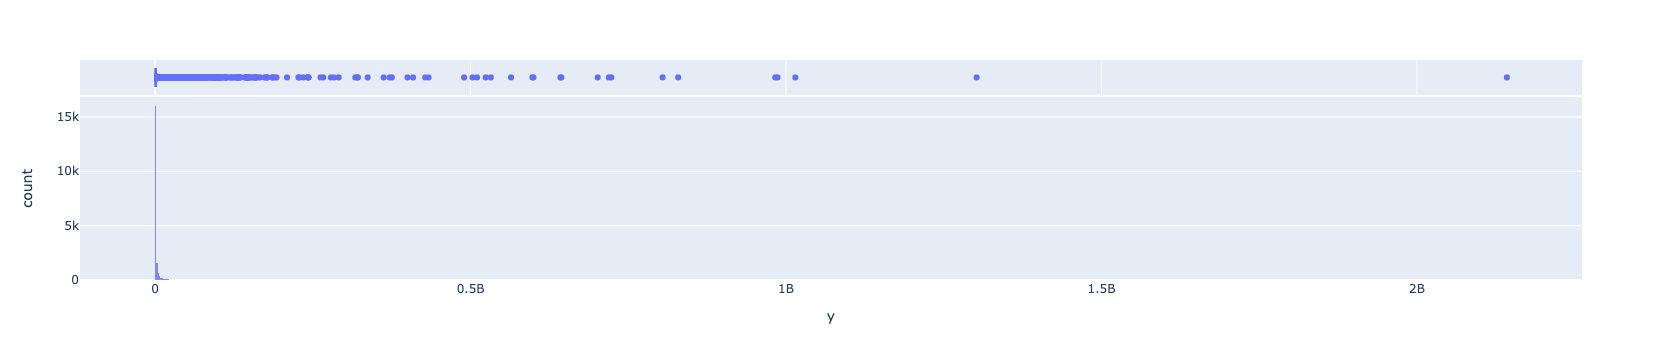

In [49]:
fig = px.histogram(train_df, x='y', width=1000, height=300, opacity=0.8, marginal='box')
fig.update_layout(barmode='overlay')
fig.show()

# カテゴリIDとチャンネルIDをlikes / dislikesでターゲットエンコードする

In [34]:
temp_df = train_df[['title', 'channelId', 'likes']]

In [43]:
def get_leave_one_out_encoder(df, cols, target):
    """looエンコード"""
    ce_loo = ce.LeaveOneOutEncoder(cols=cols).fit_transform(X=df[cols], y=df[target])
    df[f'loo_encode_{cols}'] = ce_loo
    return df

In [44]:
_temp = get_leave_one_out_encoder(temp_df, 'channelId', 'likes')

In [45]:
_temp.query('channelId == 4')

,title,channelId,likes,channelId_loo_encode,loo_encode_channelId
3,free frosty weekend!,4,287,87.750,87.750
5211,Oh my walmart,4,42,149.000,149.000
7159,kitty,4,130,127.000,127.000
17105,Family fight,4,162,119.000,119.000
17639,staten island ferry,4,17,155.250,155.250


In [46]:
_temp.head(20)

,title,channelId,likes,channelId_loo_encode,loo_encode_channelId
0,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,1,114,16828.086,16828.086
1,ねごと - メルシールー [Official Music Video],2,2885,16828.086,16828.086
2,VF3tb 闇よだれvsちび太 (SEGA),3,133,16828.086,16828.086
3,free frosty weekend!,4,287,87.750,87.750
4,トップ・オブ・ザ・ワールド,5,178,16828.086,16828.086
5,ゲンム や スナイプ たちとのグリーティング 💛 仮面ライダーエグゼイドスペシャルショー に...,6,0,16828.086,16828.086
6,Juice=Juice『「ひとりで生きられそう」って それってねえ、褒めているの？』(Pro...,7,36905,4477.100,4477.100
7,Yersiz7-5/8,8,5,6.250,6.250
8,ドリフト専用 GT-R開発ストーリーⅡ ～進化するモンスターマシン 【本編】｜TOYO TIRES,9,4638,16828.086,16828.086
9,BUMP OF CHICKEN「話がしたいよ」,10,80206,29227.615,29227.615


# titleに含まれるwordでカテゴリ分けする

In [15]:
temp_df = train_df[['title', 'tags', 'publishedAt', 'delta_month', 'channel_continue_month', 'channel_continue_day', 'in_word_anime',
'in_word_cm',
'in_word_kids',
'in_word_music',
'in_word_nursery',
'in_word_official',
'in_word_song',
'in_word_video',]]

In [16]:
temp_df.head()

,title,tags,publishedAt,delta_month,channel_continue_month,channel_continue_day,in_word_anime,in_word_cm,in_word_kids,in_word_music,in_word_nursery,in_word_official,in_word_song,in_word_video
0,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,2011-01-09 05:50:33+00:00,110.300,0.000,0.000,0,0,0,1,0,0,1,0
1,ねごと - メルシールー [Official Music Video],ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2012-07-23 03:00:09+00:00,91.833,52.300,1569.000,0,0,0,1,0,1,0,1
2,VF3tb 闇よだれvsちび太 (SEGA),VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,2007-07-26 13:54:09+00:00,151.800,0.000,0.000,0,0,0,0,0,0,0,0
3,free frosty weekend!,frosty,2005-05-15 02:38:43+00:00,177.767,2.800,84.000,0,0,0,0,0,0,0,0
4,トップ・オブ・ザ・ワールド,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,2007-09-09 09:52:47+00:00,150.100,6.833,205.000,0,0,0,0,0,0,0,0


In [17]:
temp_df.describe()

,delta_month,channel_continue_month,channel_continue_day,in_word_anime,in_word_cm,in_word_kids,in_word_music,in_word_nursery,in_word_official,in_word_song,in_word_video
count,19720.000,17413.000,17413.000,19720.000,19720.000,19720.000,19720.000,19720.000,19720.000,19720.000,19720.000
mean,94.508,6.006,180.178,0.067,0.069,0.025,0.217,0.000,0.120,0.077,0.249
std,52.603,18.096,542.879,0.249,0.253,0.157,0.412,0.000,0.325,0.266,0.432
min,1.633,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,45.858,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,96.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,143.608,0.133,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,178.467,157.733,4732.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000


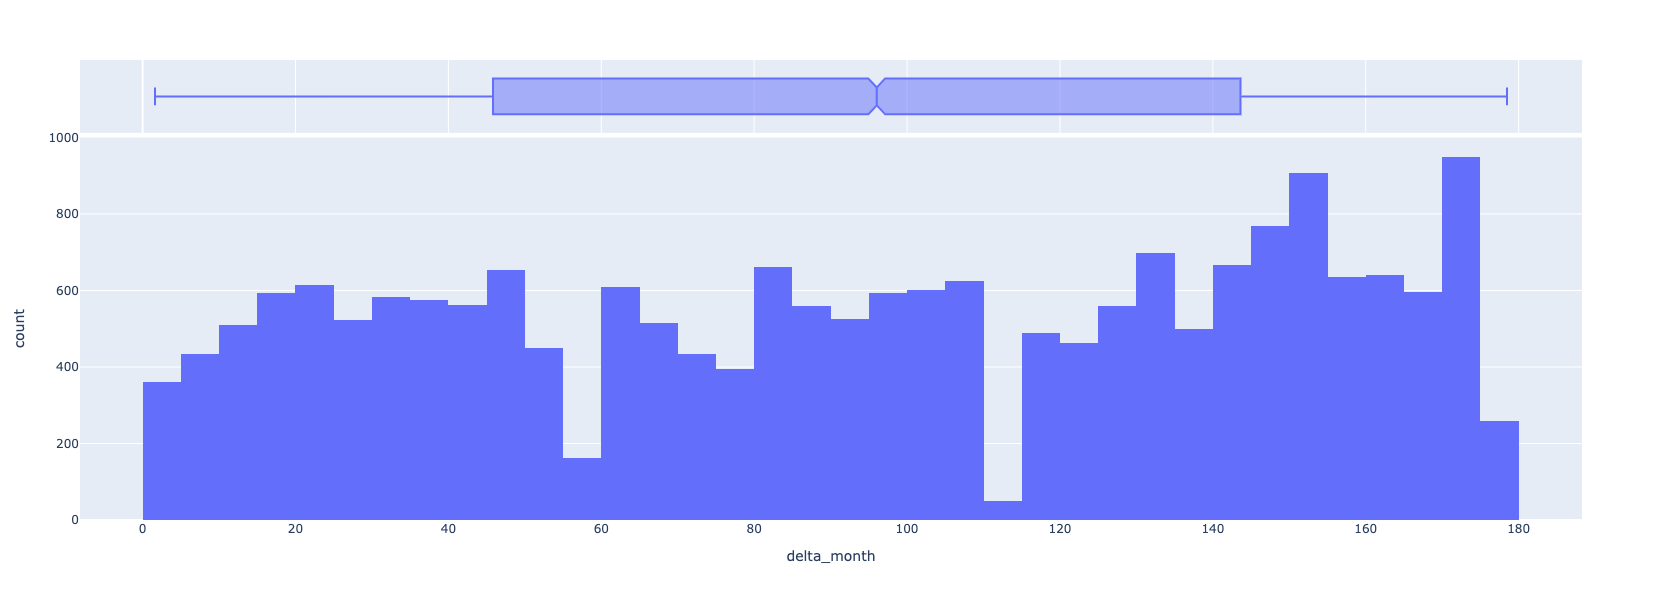

In [18]:
fig = px.histogram(temp_df, x='delta_month', width=1000,
                   height=600, marginal='box')
fig.update_layout(barmode='overlay')
fig.show()

In [19]:
bin_edges = [-float('inf'), 6, 12, 18, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, float('inf')]
_bin = pd.cut(
                temp_df['delta_month'],
                bin_edges,
                labels=False
)
temp_df['delta_month_bin'] = _bin.values

In [22]:
temp_df.describe()

,delta_month,channel_continue_month,channel_continue_day,in_word_anime,in_word_cm,in_word_kids,in_word_music,in_word_nursery,in_word_official,in_word_song,in_word_video,delta_month_bin
count,19720.000,17413.000,17413.000,19720.000,19720.000,19720.000,19720.000,19720.000,19720.000,19720.000,19720.000,19720.000
mean,94.508,6.006,180.178,0.067,0.069,0.025,0.217,0.000,0.120,0.077,0.249,9.270
std,52.603,18.096,542.879,0.249,0.253,0.157,0.412,0.000,0.325,0.266,0.432,4.567
min,1.633,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,45.858,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000
50%,96.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.000
75%,143.608,0.133,4.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,13.000
max,178.467,157.733,4732.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000,16.000


In [96]:
temp_df[(temp_df['in_music_title']) | (temp_df['in_music_tags']) | (temp_df['in_music_description'])]
# df[df["name"] == "Satoh"]

,title,tags,description,in_music_title,in_music_tags,in_music_description
0,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,False,True,False
1,ねごと - メルシールー [Official Music Video],ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,True,False,False
6,Juice=Juice『「ひとりで生きられそう」って それってねえ、褒めているの？』(Pro...,Juice=Juice|JuiceJuice|ジュースジュース|ジュース|ハロー！プロジェク...,2019年6月5日発売のJuice=Juice 12thシングル『「ひとりで生きられそう」っ...,False,True,False
9,BUMP OF CHICKEN「話がしたいよ」,BUMP OF CHICKEN|億男,BUMP OF CHICKEN「話がしたいよ」※映画『億男』主題歌2018.10.15 (m...,False,False,True
12,Gentle Light/Світе Тихий - Roman Hurko/Роман Г...,roman|hurko|christian|byzantine|choral|rite|ch...,http://www.romanhurko.comRoman Hurko's sacred ...,False,True,True
16,布袋寅泰- MATERIALS（HOTEI LIVE IN LONDON）,Hotei|Battle Without Honor or Humanity|Kill Bi...,2014.8.27発売 LIVE Blu-ray/DVD「HOTEI LIVE IN LON...,False,True,False
18,Foo Fighters - The Pretender,in your honour|FooFightersVevo|FooFightersvevo...,Foo Fighters' official music video for 'The Pr...,False,True,True
19,R.E.M. Imitation Of Life- Live,REM|Imitation|Music|Live|Concert|Michael|Stipe,R.E.M. Imitation Of Life- Live South Africa Fr...,False,True,False


In [105]:
temp_df.loc[:, 'in_word_music'] = 0
temp_df.loc[(temp_df['in_music_title'] == True) | (temp_df['in_music_tags'] == True) | (temp_df['in_music_description'] == True), 'in_word_music'] = 1

In [106]:
temp_df

,title,tags,description,in_music_title,in_music_tags,in_music_description,inword_category_type,in_word_music
0,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,False,True,False,2,1
1,ねごと - メルシールー [Official Music Video],ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,True,False,False,2,1
2,VF3tb 闇よだれvsちび太 (SEGA),VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,Beat-tribe cup finalhttp://ameblo.jp/siropai/,False,False,False,0,0
3,free frosty weekend!,frosty,I look so bad but look at me!,False,False,False,0,0
4,トップ・オブ・ザ・ワールド,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,ソロギターのしらべより「トップオブザワールド」です。クラシックギターで弾いてます。Offic...,False,False,False,0,0
5,ゲンム や スナイプ たちとのグリーティング 💛 仮面ライダーエグゼイドスペシャルショー に...,ゲンム|スナイプ|グリーティング|仮面ライダーエグゼイド|ジュウオウジャー|魔法学校の制服|...,先日のよみうりランドで行われた「 仮面ライダーエグゼイドスペシャルショー」の時のグリーティン...,False,False,False,0,0
6,Juice=Juice『「ひとりで生きられそう」って それってねえ、褒めているの？』(Pro...,Juice=Juice|JuiceJuice|ジュースジュース|ジュース|ハロー！プロジェク...,2019年6月5日発売のJuice=Juice 12thシングル『「ひとりで生きられそう」っ...,False,True,False,2,1
7,Yersiz7-5/8,5,5,False,False,False,0,0
8,ドリフト専用 GT-R開発ストーリーⅡ ～進化するモンスターマシン 【本編】｜TOYO TIRES,Drift|Drifting|Nissan GT-R|ドリフト|Team TOYO TIRE...,競技のためのドリフト走行のみを見据え、開発されたTeam TOYO TIRES DRIFTの...,False,False,False,0,0
9,BUMP OF CHICKEN「話がしたいよ」,BUMP OF CHICKEN|億男,BUMP OF CHICKEN「話がしたいよ」※映画『億男』主題歌2018.10.15 (m...,False,False,True,2,1


# チャンネルごとの継続期間

In [70]:
temp_df = train_df.query('channelId == 1 | channelId == 10 | channelId == 15')

In [83]:
gr_min = temp_df.groupby('channelId')['publishedAt'].min().reset_index().rename(columns={'publishedAt': 'publishedAt_min'})
gr_max = temp_df.groupby('channelId')['publishedAt'].max().reset_index().rename(columns={'publishedAt': 'publishedAt_max'})

In [84]:
gr_min

,channelId,publishedAt_min
0,1,2011-01-09 05:50:33+00:00
1,10,2011-02-18 14:14:18+00:00
2,15,2008-03-30 20:27:45+00:00


In [85]:
gr_max

,channelId,publishedAt_max
0,1,2011-01-09 05:50:33+00:00
1,10,2019-07-15 19:00:05+00:00
2,15,2012-11-27 07:14:07+00:00


In [86]:
continue_df = pd.merge(gr_min, gr_max, how='left', on='channelId')

In [87]:
continue_df

,channelId,publishedAt_min,publishedAt_max
0,1,2011-01-09 05:50:33+00:00,2011-01-09 05:50:33+00:00
1,10,2011-02-18 14:14:18+00:00,2019-07-15 19:00:05+00:00
2,15,2008-03-30 20:27:45+00:00,2012-11-27 07:14:07+00:00


In [90]:
continue_df['continue_delta'] = (continue_df['publishedAt_max'] - continue_df['publishedAt_min']).apply(lambda x: x.days)  # 公開されてから収集するまでの日付

In [91]:
continue_df

,channelId,publishedAt_min,publishedAt_max,continue_delta
0,1,2011-01-09 05:50:33+00:00,2011-01-09 05:50:33+00:00,0
1,10,2011-02-18 14:14:18+00:00,2019-07-15 19:00:05+00:00,3069
2,15,2008-03-30 20:27:45+00:00,2012-11-27 07:14:07+00:00,1702


## deltaで特徴量を作れないか

In [44]:
temp_df = train_df[['title', 'publishedAt', 'collection_date_after', 'delta', 'delta_published', 'dislikes', 'likes']].head(50)

In [46]:
temp_df['delta_month'] = temp_df['delta'] / 30

In [48]:
temp_df['publishedAt'].min()

Timestamp('2005-05-15 02:38:43+0000', tz='UTC')

In [47]:
temp_df

,title,publishedAt,collection_date_after,delta,delta_published,dislikes,likes,delta_month
0,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09 05:50:33+00:00,2020-02-01 00:00:00+00:00,3309,2086,0,114,110.300
1,ねごと - メルシールー [Official Music Video],2012-07-23 03:00:09+00:00,2020-02-08 00:00:00+00:00,2755,2646,50,2885,91.833
2,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26 13:54:09+00:00,2020-01-14 00:00:00+00:00,4554,823,17,133,151.800
3,free frosty weekend!,2005-05-15 02:38:43+00:00,2019-12-22 00:00:00+00:00,5333,20,51,287,177.767
4,トップ・オブ・ザ・ワールド,2007-09-09 09:52:47+00:00,2020-01-08 00:00:00+00:00,4503,868,6,178,150.100
5,ゲンム や スナイプ たちとのグリーティング 💛 仮面ライダーエグゼイドスペシャルショー に...,2017-01-11 00:34:20+00:00,2020-02-09 00:00:00+00:00,1123,4279,0,0,37.433
6,Juice=Juice『「ひとりで生きられそう」って それってねえ、褒めているの？』(Pro...,2019-05-24 08:00:11+00:00,2020-02-09 00:00:00+00:00,260,5143,394,36905,8.667
7,Yersiz7-5/8,2007-09-01 21:24:46+00:00,2020-01-08 00:00:00+00:00,4511,860,3,5,150.367
8,ドリフト専用 GT-R開発ストーリーⅡ ～進化するモンスターマシン 【本編】｜TOYO TIRES,2017-06-27 10:55:01+00:00,2020-02-09 00:00:00+00:00,956,4447,300,4638,31.867
9,BUMP OF CHICKEN「話がしたいよ」,2018-10-14 15:00:02+00:00,2020-02-09 00:00:00+00:00,482,4921,1545,80206,16.067
